# Assignment 4 Machine Learning

NIM              : 2602063913

NAME             : Bernardus Ignasio

CLASS            : LA01

Assignment Number: 4

### Importing library and datasets

In [72]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_score,recall_score,f1_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [73]:
df=pd.read_csv('cell_samples.csv')
df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


### EDA & Preprocessing

In [74]:
df=df.drop(['ID'], axis=1)

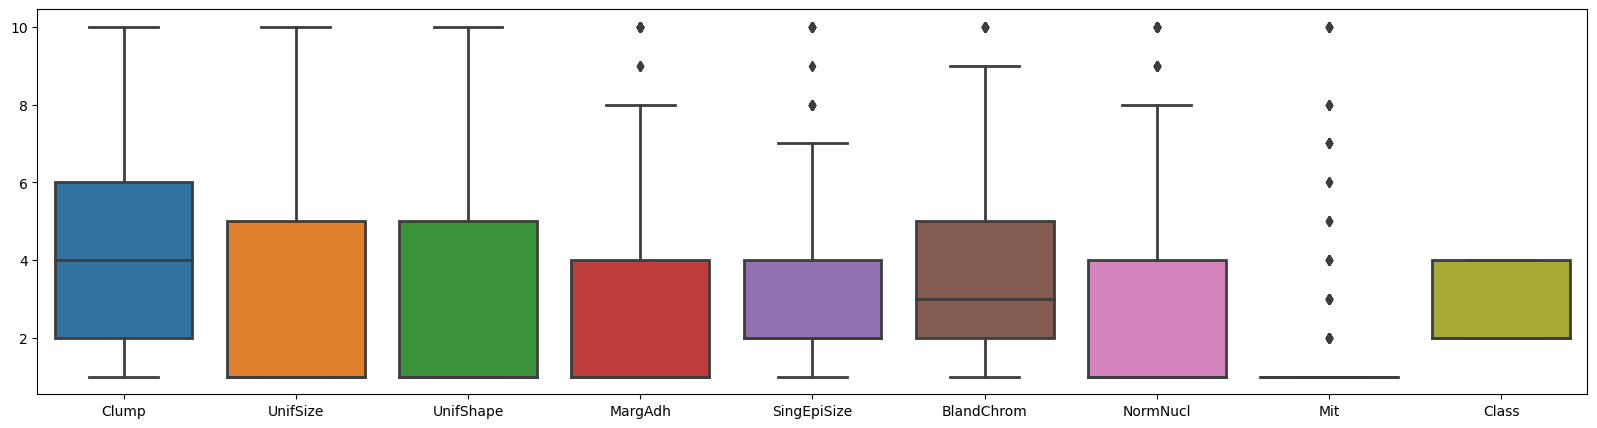

In [75]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=df,linewidth=2,ax=ax)
plt.show()

#### Terlihat pada boxplot bahwa banyak outliers yang harus di handle

In [76]:
df.dtypes

Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [77]:
df['BareNuc'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

#### Ada value yang seharusnya tidak ada di kolom'BareNuc' berupa '?' menyebabkan error dan tidak bisa fit data, maka di handling

In [78]:
df[df['BareNuc'] == '?'] = df['BareNuc'].mode()[0]

In [79]:
df=df.astype('int64')
df.dtypes

Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [80]:
df['Class'].unique()

array([2, 4, 1], dtype=int64)

#### terdapat 3 value di kolom 'class' diminta hanya classify hanya 2 (benign) dan 4 (malignant), maka harus di handling

In [81]:
a = []
for idx,i in enumerate(df['Class']):
    if i == 1:
        a.append(idx)


In [82]:
a

[23, 40, 139, 145, 158, 164, 235, 249, 275, 292, 294, 297, 315, 321, 411, 617]

In [83]:
df = df.drop(a)

In [84]:
df['Class'].unique()

array([2, 4], dtype=int64)

In [85]:
#kalau class 1 nya mau di mode
#df['Class'].groupby(df['Class']).count()
#df[df['Class'] == 1] = df['Class'].mode()[0]

In [86]:
#df['Class'].unique()

In [87]:
def data_preprocessing_pipeline(data):
    numeric_features=data.select_dtypes(include=['float','int']).columns
    categorical_features=data.select_dtypes(include=['object']).columns
    
    data[numeric_features]=data[numeric_features].fillna(data[numeric_features].mean())
    
    for feature in numeric_features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3-Q1
        lower_bound= Q1 - (1.5*IQR)
        upper_bound= Q3 + (1.5*IQR)
        data[feature]= np.where((data[feature]<lower_bound) | (data[feature]> upper_bound), 
                                 data[feature].mean(), data[feature])
                                
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[numeric_features])
    data[numeric_features]=scaler.transform(data[numeric_features])
    #data[categorical_features]=data[categorical_features].fillna(data[categorical_features].mode().iloc[0])
    return data                            

In [88]:
data_preprocessing_pipeline(df) 
df.head()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,0.197905,-0.702212,-0.741774,-0.654577,-0.563025,-0.698853,-0.116804,-0.598251,-0.461675,-0.733681
1,0.197905,0.277252,0.262783,1.497467,3.122838,1.772867,-0.116804,-0.058643,-0.461675,-0.733681
2,-0.511643,-0.702212,-0.741774,-0.654577,-0.563025,-0.424217,-0.116804,-0.598251,-0.461675,-0.733681
3,0.552679,1.583204,1.602192,-0.654577,0.174148,0.125054,-0.116804,2.639393,-0.461675,-0.733681
4,-0.156869,-0.702212,-0.741774,0.421445,-0.563025,-0.698853,-0.116804,-0.598251,-0.461675,-0.733681


#### Data setelah distandarisasi agar memiliki scale yang sama

In [89]:
df.dtypes

Clump          float64
UnifSize       float64
UnifShape      float64
MargAdh        float64
SingEpiSize    float64
BareNuc        float64
BlandChrom     float64
NormNucl       float64
Mit            float64
Class          float64
dtype: object

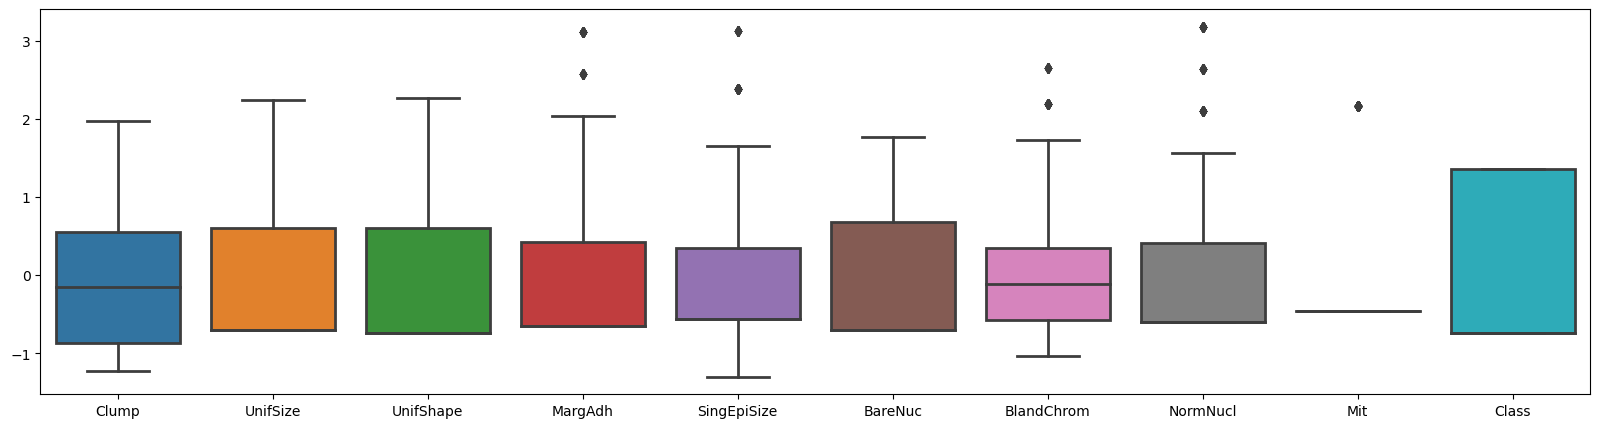

In [90]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=df,linewidth=2,ax=ax)
plt.show()

#### Dapat terlihat bahwa outliers sudah berkurang

In [91]:
df['Class'].unique()

array([-0.73368133,  1.36298958])

In [92]:
df['BareNuc'].unique()

array([-0.69885309,  1.77286724, -0.4242175 ,  0.12505369, -0.1495819 ,
        1.49823165,  0.94896047,  0.39968928,  1.22359606,  0.67432487])

### Fitting & Predict with SVC RBF Kernel

In [93]:
X=df.drop(['Class'],axis=1)
y=df['Class'].astype('int64')

In [94]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [95]:
y_test

304    1
149    1
217    0
120    0
314    0
      ..
112    1
84     1
53     1
216    0
563    0
Name: Class, Length: 137, dtype: int64

In [96]:
svc=SVC(kernel='rbf')
svc.fit(X_train,y_train)

SVC()

In [97]:
y_pred=svc.predict(X_test)

### Evaluation

In [98]:
print(f'Accuracy Score : {accuracy_score(y_test,y_pred)}')
print(f'Precision Score : {precision_score(y_test,y_pred)}')
print(f'Recall Score : {recall_score(y_test,y_pred)}')
print(f'F1 Score : {f1_score(y_test,y_pred)}')

Accuracy Score : 0.9781021897810219
Precision Score : 0.9824561403508771
Recall Score : 0.9655172413793104
F1 Score : 0.9739130434782608


In [99]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        79
           1       0.98      0.97      0.97        58

    accuracy                           0.98       137
   macro avg       0.98      0.98      0.98       137
weighted avg       0.98      0.98      0.98       137



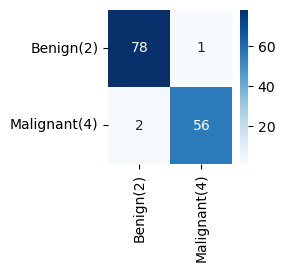

In [102]:
fig, ax = plt.subplots(figsize=(2, 2))
axislabel=['Benign(2)','Malignant(4)']

sns.heatmap(confusion_matrix(y_test,y_pred),xticklabels=axislabel, yticklabels=axislabel, annot=True,cmap='Blues')




plt.show()